# Imports

In [ ]:
import os, sys
# Add the conda env's Library\bin to the DLL search path
env = sys.exec_prefix    
bin_dir = os.path.join(env, "Library", "bin")
os.add_dll_directory(bin_dir)

# imports will find the required DLLs
from pathlib import Path
from typing import Callable, Dict, Tuple
import torchvision.transforms.functional as TF
from PIL import Image 

from pathlib import Path
from typing import Callable, Dict, Tuple
import torchvision.transforms.functional as TF
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from matplotlib import pyplot as plt
import numpy as np
import cv2   
from tqdm import tqdm
import torch, torch.nn as nn
import platform

In [4]:
import torch, sys, platform
print("torch           :", torch.__version__)
print("compiled w/ CUDA:", torch.version.cuda)
print("is_available    :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU             :", torch.cuda.get_device_name(0))

torch           : 2.3.1+cu121
compiled w/ CUDA: 12.1
is_available    : True
GPU             : NVIDIA GeForce RTX 4060 Laptop GPU


# Loading

In [ ]:
class DriveLocal(Dataset):
    exts = (".tif", ".tiff", ".gif", ".png")

    def __init__(self, root: str | Path, split: str = "training",
                 transforms: Callable | None = None):
        if split not in {"training", "test"}:
            raise ValueError("split must be 'training' or 'test'")

        root = Path(root).expanduser()
        self.split, self.transforms = split, transforms

        self.img_dir  = root / split / "images"
        self.mask_dir = root / split / "1st_manual"   # may be missing for test
        self.fov_dir  = root / split / "mask"

        self.ids = sorted(p.stem[:2]                   
                          for p in self.img_dir.glob("*")
                          if p.suffix.lower() in self.exts)
        if not self.ids:
            raise RuntimeError(f"No .tif images found in {self.img_dir}")

    # ----------------------------------------------------------

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]

        image_path = self.img_dir / f"{img_id}_{self.split}.tif"
        fov_path   = self.fov_dir / f"{img_id}_{self.split}_mask.gif"
        mask_path  = self.mask_dir / f"{img_id}_manual1.gif"

        # load required files
        img  = TF.to_tensor(Image.open(image_path).convert("RGB"))
        fov  = TF.to_tensor(Image.open(fov_path ).convert("L")) > 0.5

        sample = {
            "image": img.float(),
            "fov":   fov.float(),
            "name":  image_path.stem,             # unchanged
            "image_file": image_path.name,
            "fov_file":   fov_path.name,
        }

        # add vessel GT if present
        if self.split == "training" or mask_path.exists():
            mask = TF.to_tensor(Image.open(mask_path).convert("L")) > 0.5
            sample["mask"] = mask.float()
            sample["mask_file"] = mask_path.name   # NEW

        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [6]:
root = r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\Drive Dataset"
train_ds = DriveLocal(root, "training")
print(len(train_ds))     
print(train_ds[0]["name"]) 

20
21_training


In [7]:
test_ds = DriveLocal(root, split="test")   
print("test images:", len(test_ds))  
print(test_ds[0]["name"])     

test images: 20
01_test


# Visualization

In [ ]:
# helpers
def to_np(t):
    """(C,H,W) float 0-1  →  uint8 (H,W,3)"""
    if t.ndim == 3 and t.size(0) == 1:
        t = t.expand(3, -1, -1)
    return (t.clamp(0, 1) * 255).byte().permute(1, 2, 0).cpu().numpy()


def gray_3c(mask):
    """bool / byte mask  →  3-channel gray uint8"""
    g = mask.squeeze().byte().cpu().numpy() * 255
    return np.stack([g] * 3, axis=-1)


# plotting
def show_training(ds, n_rows: int = 5):
    """grid: fundus | manual vessels | FOV mask"""
    fig, axes = plt.subplots(n_rows, 3, figsize=(12, 3 * n_rows))
    plt.subplots_adjust(wspace=0, hspace=0.08)

    for r in range(n_rows):
        sample = ds[r]
        panels = [
            to_np(sample["image"]),          # fundus
            gray_3c(sample["mask"]),         # manual vessels
            gray_3c(sample["fov"]),          # FOV mask
        ]
        titles = [
            sample["image_file"],
            sample["mask_file"],
            sample["fov_file"],
        ]

        for ax, title, pic in zip(axes[r], titles, panels):
            ax.imshow(pic)
            ax.set_title(title, fontsize=8)
            ax.axis("off")

    fig.suptitle("Training Images — fundus / vessels / mask", fontsize=16, y=0.93)
    plt.show()


def show_test(ds, n_rows: int = 5):
    """grid: fundus | FOV mask"""
    fig, axes = plt.subplots(n_rows, 2, figsize=(8, 3 * n_rows))
    plt.subplots_adjust(wspace=0, hspace=0.08)

    for r in range(n_rows):
        sample = ds[r]
        panels = [
            to_np(sample["image"]),      # fundus
            gray_3c(sample["fov"]),      # FOV mask
        ]
        titles = [
            sample["image_file"],
            sample["fov_file"],
        ]

        for ax, title, pic in zip(axes[r], titles, panels):
            ax.imshow(pic)
            ax.set_title(title, fontsize=8)
            ax.axis("off")

    fig.suptitle("Test Images — fundus / mask", fontsize=16, y=0.93)
    plt.show()


Test Images + Masks

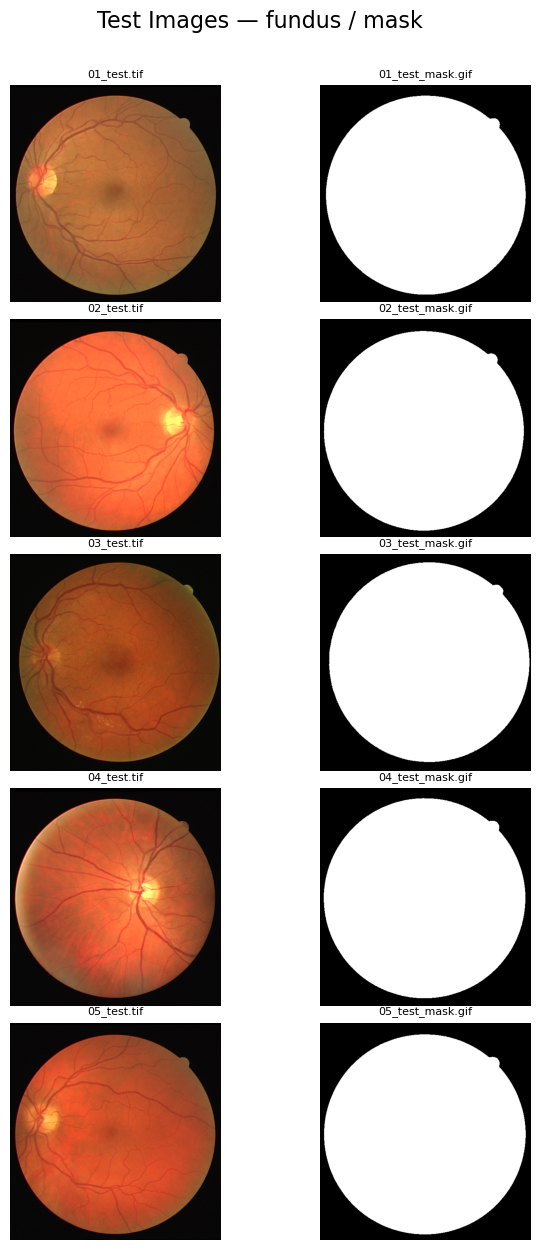

In [9]:
show_test(test_ds, n_rows=5)   

Training Images + Manual Vessel Drawings + Masks

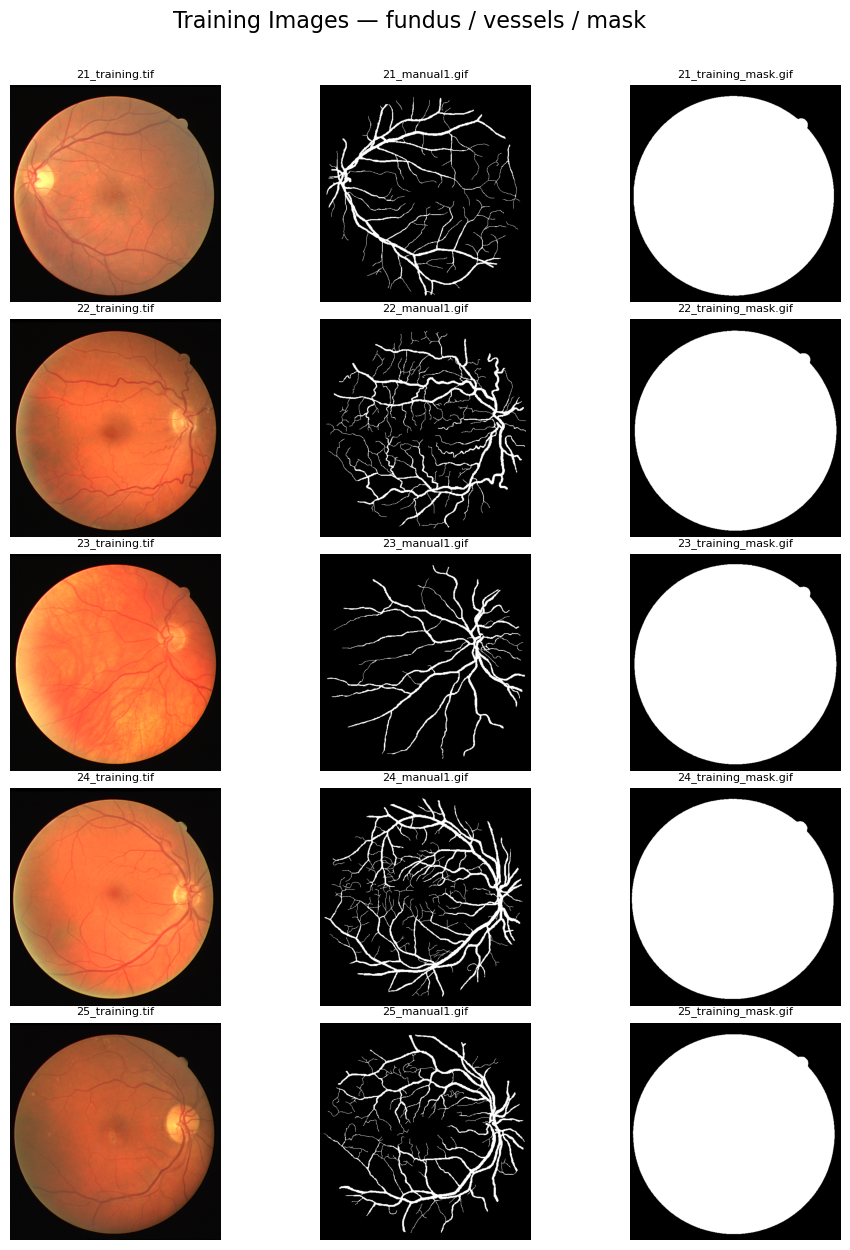

In [10]:
show_training(train_ds, n_rows=5)

# Preprocessing

In [ ]:
ROOT = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\Drive Dataset")
TARGET_SIZE = (512, 512)         # (H, W)
CLAHE_CLIP  = 2.0
CLAHE_GRID  = 8
GAUSS_SIGMA = 40                 # illumination blur kernel σ
OUT_ROOT    = ROOT.parent / f"{ROOT.name}-pre"

# helper functions
def ensure(p: Path):
    p.mkdir(parents=True, exist_ok=True)


def to_float(u8):
    return u8.astype(np.float32) / 255.0


def to_uint8(f32):
    return np.clip(f32 * 255.0, 0, 255).astype(np.uint8)


def clahe_rgb_float(img_f):
    """CLAHE on the L* channel; works in float, returns float."""
    img_u = to_uint8(img_f)
    lab = cv2.cvtColor(img_u, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP,
                            tileGridSize=(CLAHE_GRID, CLAHE_GRID))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    out_u = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return to_float(out_u)


def shade_correct_gauss(img_f, mask_bin):
    """Subtract heavy blur, rescale 0–1 inside mask only."""
    blur = cv2.GaussianBlur(img_f, (0, 0), GAUSS_SIGMA)
    flat = img_f - blur
    # rescale contrast inside the FOV
    m = mask_bin.astype(bool)
    if m.any():
        lo, hi = flat[m].min(), flat[m].max()
        flat = (flat - lo) / (hi - lo + 1e-6)
    flat[~m] = 0.0
    return flat


def crop_pad_square(img, mask_bin):
    ys, xs = np.where(mask_bin)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    crop = img[y0:y1 + 1, x0:x1 + 1]

    h, w = crop.shape[:2]
    d = max(h, w)
    pad_t = (d - h) // 2
    pad_b = d - h - pad_t
    pad_l = (d - w) // 2
    pad_r = d - w - pad_l
    return cv2.copyMakeBorder(crop, pad_t, pad_b, pad_l, pad_r,
                              cv2.BORDER_CONSTANT, value=0)


def resize(img, size):
    interp = cv2.INTER_NEAREST if img.ndim == 2 or img.shape[2] == 1 else cv2.INTER_AREA
    return cv2.resize(img, (size[1], size[0]), interpolation=interp)

# core routine
def process_split(split: str):
    ds = DriveLocal(ROOT, split)
    out_img = OUT_ROOT / split / "images"
    out_msk = OUT_ROOT / split / "masks"
    out_ves = OUT_ROOT / split / "vessels"  # only for training

    ensure(out_img); ensure(out_msk)
    if split == "training":
        ensure(out_ves)

    for sample in tqdm(ds, desc=f"{split:8s}"):
        stem = sample["name"].split('.')[0]          # '01_training'
        # RGB → BGR then float32
        img_bgr = cv2.cvtColor(
            (sample["image"].permute(1, 2, 0).numpy() * 255).astype(np.uint8),
            cv2.COLOR_RGB2BGR
        )
        img_f   = to_float(img_bgr)
        mask_bin = sample["fov"].squeeze().numpy().astype(bool)

        # 1 mask
        img_f[~mask_bin] = 0.0
        # 2 CLAHE
        img_f = clahe_rgb_float(img_f)
        # 3 shading correction
        img_f = shade_correct_gauss(img_f, mask_bin)
        # 4 crop & pad
        img_f     = crop_pad_square(img_f, mask_bin)
        mask_crop = crop_pad_square(mask_bin.astype(np.uint8)*255, mask_bin)

        # 5 resize
        img_f     = resize(img_f, TARGET_SIZE)
        mask_crop = resize(mask_crop, TARGET_SIZE)

        # save fundus & mask
        cv2.imwrite(str(out_img / f"{stem}.png"), to_uint8(img_f))
        cv2.imwrite(str(out_msk / f"{stem}_mask.png"), mask_crop)

        # vessel masks (training only)
        if split == "training":
            vess = (sample["mask"].squeeze().numpy() * 255).astype(np.uint8)
            vess_crop = crop_pad_square(vess, mask_bin)
            vess_crop = resize(vess_crop, TARGET_SIZE)
            cv2.imwrite(str(out_ves / f"{stem}_vessels.png"), vess_crop)


In [12]:
print("Pre-processing DRIVE …")
process_split("training")
process_split("test")
print(f"Done ✔  Outputs in: {OUT_ROOT}")

Pre-processing DRIVE …


test    : 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]

Done ✔  Outputs in: C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\Drive Dataset-pre


In [13]:
PRE = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\Drive Dataset-pre")
def load_rgb(path):
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(path)
    if img.ndim == 2:                        # gray → RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:                                    # BGR → RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def tensor_rgb(t):
    return (t.permute(1, 2, 0).numpy() * 255).astype(np.uint8)


# -----------------------------------------------------------
def show_training(n=5):
    ds = DriveLocal(ROOT, "training")
    fig, axes = plt.subplots(n, 3, figsize=(12, 3 * n))
    plt.subplots_adjust(wspace=0, hspace=0.15)

    for i in range(n):
        sample = ds[i]
        stem = sample["name"].split(".")[0]

        orig = tensor_rgb(sample["image"])
        pre  = load_rgb(PRE / "training" / "images"   / f"{stem}.png")
        vess = load_rgb(PRE / "training" / "vessels" / f"{stem}_vessels.png")

        for ax, img, lbl in zip(axes[i],
                                [orig, pre, vess],
                                ["original", "pre-processed", "vessels"]):
            ax.imshow(img); ax.axis("off")
            ax.set_title(f"{stem}\n{lbl}", fontsize=8)

    fig.suptitle("TRAINING — original · pre-processed · vessels", fontsize=16, y=0.93)
    plt.show()


def show_test(n=5):
    ds = DriveLocal(ROOT, "test")
    fig, axes = plt.subplots(n, 2, figsize=(8, 3 * n))
    plt.subplots_adjust(wspace=0, hspace=0.15)

    for i in range(n):
        sample = ds[i]
        stem = sample["name"].split(".")[0]

        orig = tensor_rgb(sample["image"])
        pre  = load_rgb(PRE / "test" / "images" / f"{stem}.png")

        for ax, img, lbl in zip(axes[i],
                                [orig, pre],
                                ["original", "pre-processed"]):
            ax.imshow(img); ax.axis("off")
            ax.set_title(f"{stem}\n{lbl}", fontsize=8)

    fig.suptitle("TEST — original · pre-processed", fontsize=16, y=0.93)
    plt.show()

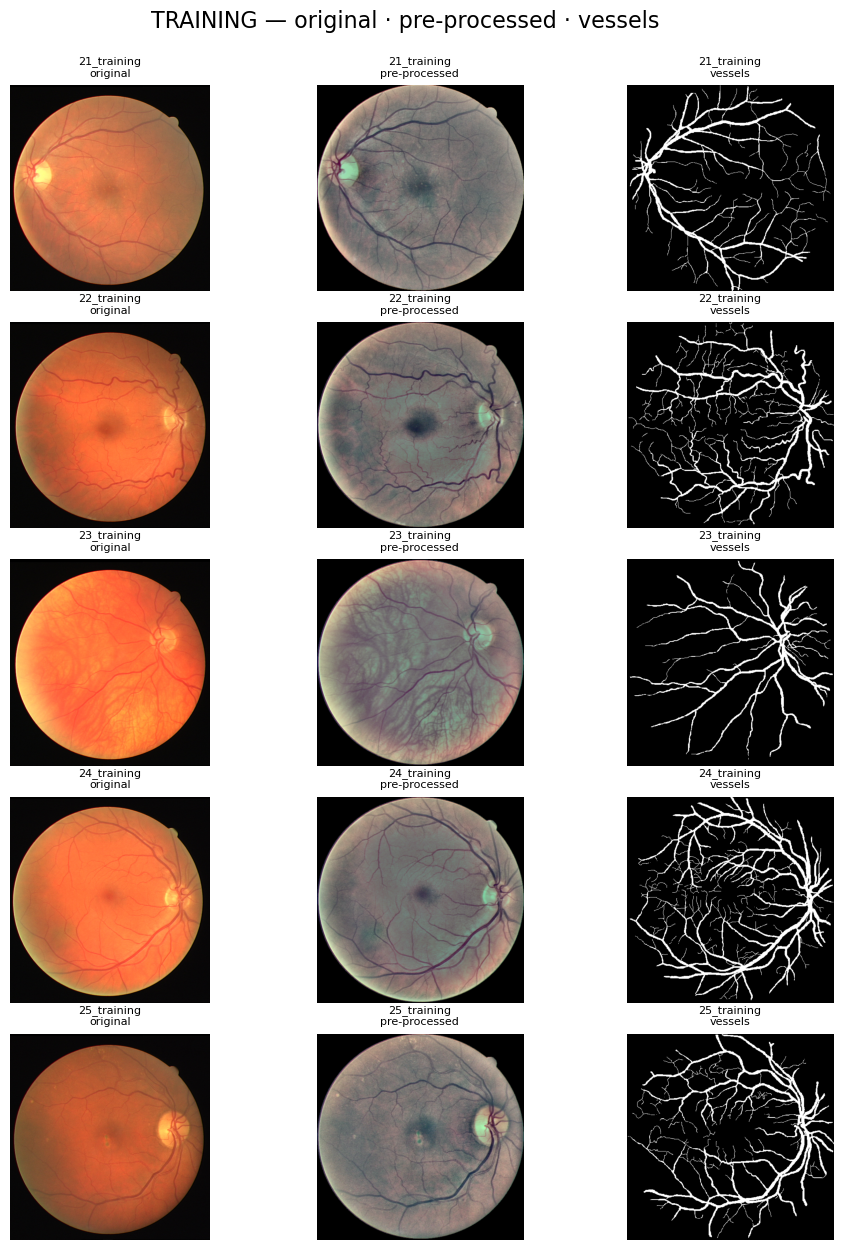

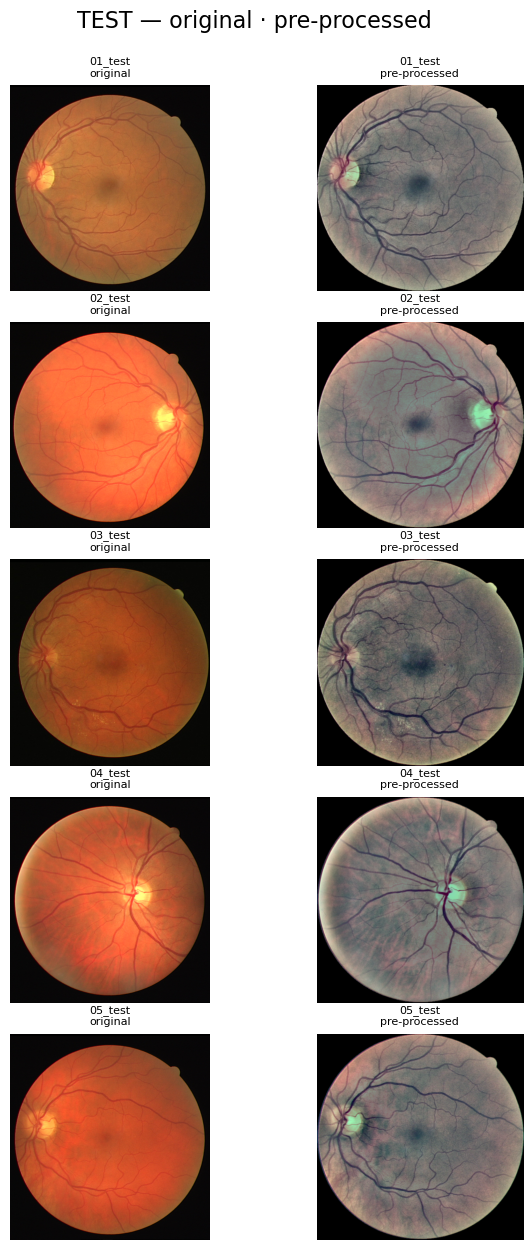

In [14]:
show_training(5)
show_test(5)

# Model

In [15]:
# ───────── simple U-Net (5 levels) ───────────────────────────
def C(in_ch, out_ch):  # conv-block
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = C(3,   32)
        self.d2 = C(32,  64)
        self.d3 = C(64, 128)
        self.d4 = C(128,256)
        self.mid= C(256,512)
        self.u4 = C(512+256,256)
        self.u3 = C(256+128,128)
        self.u2 = C(128+64 ,64)
        self.u1 = C(64 +32 ,32)
        self.out= nn.Conv2d(32,1,1)

        self.pool = nn.MaxPool2d(2)
        self.up   = lambda x: nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)

    def forward(self,x):
        d1 = self.d1(x); p1 = self.pool(d1)
        d2 = self.d2(p1); p2 = self.pool(d2)
        d3 = self.d3(p2); p3 = self.pool(d3)
        d4 = self.d4(p3); p4 = self.pool(d4)
        mid= self.mid(p4)
        u4 = self.u4(torch.cat([self.up(mid), d4],1))
        u3 = self.u3(torch.cat([self.up(u4), d3],1))
        u2 = self.u2(torch.cat([self.up(u3), d2],1))
        u1 = self.u1(torch.cat([self.up(u2), d1],1))
        return torch.sigmoid(self.out(u1))

# ───────── loss & metric ─────────────────────────────────────
def dice_coeff(p, t, eps=1e-7):
    p, t = p.flatten(1), t.flatten(1)
    inter = (p*t).sum(1)
    return ((2*inter + eps)/(p.sum(1)+t.sum(1)+eps)).mean()

bce = nn.BCELoss()
def combo_loss(pred, targ):
    return bce(pred, targ) + (1 - dice_coeff(pred, targ))

# Model training

In [32]:
ROOT_PRE = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\Drive Dataset-pre\training")
IMG_DIR  = ROOT_PRE / "images"
LAB_DIR  = ROOT_PRE / "vessels"

# hyperparameters
BATCH     = 4
EPOCHS    = 200
LR        = 8e-4
VAL_SPLIT = 0.25
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
print("torch", torch.__version__, "cuda", torch.version.cuda)
print("is_available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))

torch 2.3.1+cu121 cuda 12.1
is_available: True
device: NVIDIA GeForce RTX 4060 Laptop GPU


In [34]:
# ───────── dataset for pre-processed pngs ─────────────────────
class DrivePre(Dataset):
    def __init__(self, img_dir, lab_dir):
        self.imgs = sorted(img_dir.glob("*.png"))
        self.lab_dir = lab_dir

    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        img_p = self.imgs[idx]
        lab_p = self.lab_dir / f"{img_p.stem}_vessels.png"

        img = cv2.imread(str(img_p), cv2.IMREAD_COLOR)      # BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        lab = cv2.imread(str(lab_p), cv2.IMREAD_GRAYSCALE) / 255.0

        img = torch.tensor(img, dtype=torch.float32).permute(2,0,1)
        lab = torch.tensor(lab, dtype=torch.float32).unsqueeze(0)
        return img, lab
    
# ───────── data loaders ─────────────────────────────────────
full_ds = DrivePre(IMG_DIR, LAB_DIR)
val_len = int(len(full_ds)*VAL_SPLIT)
train_ds, val_ds = random_split(full_ds, [len(full_ds)-val_len, val_len], generator=torch.Generator().manual_seed(42))

train_ld = DataLoader(train_ds, BATCH, shuffle=True, pin_memory=True)
val_ld   = DataLoader(val_ds,1,shuffle=False)

In [35]:
# training loop
model = UNet().to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR)

best_dice = 0
for epoch in range(1, EPOCHS+1):
    model.train()
    tr_loss = 0
    for img, lab in tqdm(train_ld, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
        img, lab = img.to(DEVICE), lab.to(DEVICE)
        opt.zero_grad()
        pred = model(img)
        loss = combo_loss(pred, lab)
        loss.backward(); opt.step()
        tr_loss += loss.item()*img.size(0)
    tr_loss /= len(train_ld.dataset)

    # ---- validation ----
    model.eval()
    dices = []
    with torch.no_grad():
        for img, lab in val_ld:
            img, lab = img.to(DEVICE), lab.to(DEVICE)
            pred = model(img)
            dices.append(dice_coeff(pred, lab).item())
    val_d = np.mean(dices)

    print(f"Epoch {epoch:02d}  train-loss {tr_loss:.4f}  val-Dice {val_d:.4f}")

    if val_d > best_dice:
        best_dice = val_d
        torch.save(model.state_dict(), "best_model.pth")
        print("  ✔ saved best_model.pth")

print(f"Finished. Best val Dice = {best_dice:.4f}")

Epoch 01  train-loss 1.5054  val-Dice 0.1577
  ✔ saved best_model.pth


Epoch 02  train-loss 1.2887  val-Dice 0.1570


Epoch 03  train-loss 1.2042  val-Dice 0.1521


Epoch 04  train-loss 1.1546  val-Dice 0.1494


Epoch 05  train-loss 1.1225  val-Dice 0.1456


Epoch 06  train-loss 1.0979  val-Dice 0.1495


Epoch 07  train-loss 1.0762  val-Dice 0.1595
  ✔ saved best_model.pth


Epoch 08  train-loss 1.0577  val-Dice 0.1952
  ✔ saved best_model.pth


Epoch 09  train-loss 1.0390  val-Dice 0.2356
  ✔ saved best_model.pth


Epoch 10  train-loss 1.0232  val-Dice 0.2590
  ✔ saved best_model.pth


Epoch 11  train-loss 1.0050  val-Dice 0.2816
  ✔ saved best_model.pth


Epoch 12  train-loss 0.9876  val-Dice 0.3100
  ✔ saved best_model.pth


Epoch 13  train-loss 0.9705  val-Dice 0.3212
  ✔ saved best_model.pth


Epoch 14  train-loss 0.9544  val-Dice 0.3442
  ✔ saved best_model.pth


Epoch 15  train-loss 0.9382  val-Dice 0.3648
  ✔ saved best_model.pth


Epoch 16  train-loss 0.9211  val-Dice 0.3570


Epoch 17  train-loss 0.9055  val-Dice 0.3745
  ✔ saved best_model.pth


Epoch 18  train-loss 0.8900  val-Dice 0.3806
  ✔ saved best_model.pth


Epoch 19  train-loss 0.8725  val-Dice 0.3929
  ✔ saved best_model.pth


Epoch 20  train-loss 0.8576  val-Dice 0.3894


Epoch 21  train-loss 0.8428  val-Dice 0.4060
  ✔ saved best_model.pth


Epoch 22  train-loss 0.8286  val-Dice 0.4101
  ✔ saved best_model.pth


Epoch 23  train-loss 0.8159  val-Dice 0.4171
  ✔ saved best_model.pth


Epoch 24  train-loss 0.8049  val-Dice 0.4252
  ✔ saved best_model.pth


Epoch 25  train-loss 0.7974  val-Dice 0.4362
  ✔ saved best_model.pth


Epoch 26  train-loss 0.7833  val-Dice 0.4458
  ✔ saved best_model.pth


Epoch 27  train-loss 0.7707  val-Dice 0.4406


Epoch 28  train-loss 0.7540  val-Dice 0.4582
  ✔ saved best_model.pth


Epoch 29  train-loss 0.7394  val-Dice 0.4700
  ✔ saved best_model.pth


Epoch 30  train-loss 0.7252  val-Dice 0.4588


Epoch 31  train-loss 0.7117  val-Dice 0.4574


Epoch 32  train-loss 0.6986  val-Dice 0.4634


Epoch 33  train-loss 0.6850  val-Dice 0.4884
  ✔ saved best_model.pth


Epoch 34  train-loss 0.6731  val-Dice 0.4868


Epoch 35  train-loss 0.6643  val-Dice 0.5061
  ✔ saved best_model.pth


Epoch 36  train-loss 0.6513  val-Dice 0.5147
  ✔ saved best_model.pth


Epoch 37  train-loss 0.6404  val-Dice 0.5167
  ✔ saved best_model.pth


Epoch 38  train-loss 0.6308  val-Dice 0.5302
  ✔ saved best_model.pth


Epoch 39  train-loss 0.6174  val-Dice 0.5228


Epoch 40  train-loss 0.6052  val-Dice 0.5246


Epoch 41  train-loss 0.5965  val-Dice 0.5276


Epoch 42  train-loss 0.5841  val-Dice 0.5353
  ✔ saved best_model.pth


Epoch 43  train-loss 0.5729  val-Dice 0.5560
  ✔ saved best_model.pth


Epoch 44  train-loss 0.5645  val-Dice 0.5642
  ✔ saved best_model.pth


Epoch 45  train-loss 0.5573  val-Dice 0.5539


Epoch 46  train-loss 0.5564  val-Dice 0.5698
  ✔ saved best_model.pth


Epoch 47  train-loss 0.5497  val-Dice 0.5892
  ✔ saved best_model.pth


Epoch 48  train-loss 0.5321  val-Dice 0.5836


Epoch 49  train-loss 0.5229  val-Dice 0.5774


Epoch 50  train-loss 0.5182  val-Dice 0.5917
  ✔ saved best_model.pth


Epoch 51  train-loss 0.5076  val-Dice 0.6025
  ✔ saved best_model.pth


Epoch 52  train-loss 0.4978  val-Dice 0.6002


Epoch 53  train-loss 0.4914  val-Dice 0.6094
  ✔ saved best_model.pth


Epoch 54  train-loss 0.4828  val-Dice 0.6157
  ✔ saved best_model.pth


Epoch 55  train-loss 0.4823  val-Dice 0.6192
  ✔ saved best_model.pth


Epoch 56  train-loss 0.4744  val-Dice 0.6128


Epoch 57  train-loss 0.4663  val-Dice 0.6342
  ✔ saved best_model.pth


Epoch 58  train-loss 0.4591  val-Dice 0.6175


Epoch 59  train-loss 0.4516  val-Dice 0.6436
  ✔ saved best_model.pth


Epoch 60  train-loss 0.4462  val-Dice 0.6484
  ✔ saved best_model.pth


Epoch 61  train-loss 0.4345  val-Dice 0.6460


Epoch 62  train-loss 0.4314  val-Dice 0.6570
  ✔ saved best_model.pth


Epoch 63  train-loss 0.4200  val-Dice 0.6528


Epoch 64  train-loss 0.4169  val-Dice 0.6633
  ✔ saved best_model.pth


Epoch 65  train-loss 0.4134  val-Dice 0.6608


Epoch 66  train-loss 0.4190  val-Dice 0.6609


Epoch 67  train-loss 0.4032  val-Dice 0.6681
  ✔ saved best_model.pth


Epoch 68  train-loss 0.3977  val-Dice 0.6670


Epoch 69  train-loss 0.3925  val-Dice 0.6802
  ✔ saved best_model.pth


Epoch 70  train-loss 0.3856  val-Dice 0.6838
  ✔ saved best_model.pth


Epoch 71  train-loss 0.3838  val-Dice 0.6725


Epoch 72  train-loss 0.3827  val-Dice 0.6806


Epoch 73  train-loss 0.3814  val-Dice 0.6690


Epoch 74  train-loss 0.3775  val-Dice 0.6910
  ✔ saved best_model.pth


Epoch 75  train-loss 0.3661  val-Dice 0.6907


Epoch 76  train-loss 0.3603  val-Dice 0.6947
  ✔ saved best_model.pth


Epoch 77  train-loss 0.3567  val-Dice 0.7073
  ✔ saved best_model.pth


Epoch 78  train-loss 0.3494  val-Dice 0.6904


Epoch 79  train-loss 0.3477  val-Dice 0.6998


Epoch 80  train-loss 0.3386  val-Dice 0.7037


Epoch 81  train-loss 0.3336  val-Dice 0.7086
  ✔ saved best_model.pth


Epoch 82  train-loss 0.3284  val-Dice 0.7146
  ✔ saved best_model.pth


Epoch 83  train-loss 0.3214  val-Dice 0.7024


Epoch 84  train-loss 0.3148  val-Dice 0.7111


Epoch 85  train-loss 0.3142  val-Dice 0.7122


Epoch 86  train-loss 0.3116  val-Dice 0.7179
  ✔ saved best_model.pth


Epoch 87  train-loss 0.3123  val-Dice 0.7113


Epoch 88  train-loss 0.3210  val-Dice 0.7069


Epoch 89  train-loss 0.3241  val-Dice 0.7150


Epoch 90  train-loss 0.3098  val-Dice 0.7189
  ✔ saved best_model.pth


Epoch 91  train-loss 0.3054  val-Dice 0.7036


Epoch 92  train-loss 0.3029  val-Dice 0.7206
  ✔ saved best_model.pth


Epoch 93  train-loss 0.2989  val-Dice 0.7171


Epoch 94  train-loss 0.2988  val-Dice 0.7232
  ✔ saved best_model.pth


Epoch 95  train-loss 0.2934  val-Dice 0.7176


Epoch 96  train-loss 0.2877  val-Dice 0.7341
  ✔ saved best_model.pth


Epoch 97  train-loss 0.2797  val-Dice 0.7325


Epoch 98  train-loss 0.2755  val-Dice 0.7356
  ✔ saved best_model.pth


Epoch 99  train-loss 0.2643  val-Dice 0.7288


Epoch 100  train-loss 0.2656  val-Dice 0.7221


Epoch 101  train-loss 0.2760  val-Dice 0.7354


Epoch 102  train-loss 0.2725  val-Dice 0.7381
  ✔ saved best_model.pth


Epoch 103  train-loss 0.2623  val-Dice 0.7283


Epoch 104  train-loss 0.2605  val-Dice 0.7341


Epoch 105  train-loss 0.2618  val-Dice 0.7184


Epoch 106  train-loss 0.2556  val-Dice 0.7345


Epoch 107  train-loss 0.2531  val-Dice 0.7283


Epoch 108  train-loss 0.2536  val-Dice 0.7373


Epoch 109  train-loss 0.2418  val-Dice 0.7370


Epoch 110  train-loss 0.2345  val-Dice 0.7313


Epoch 111  train-loss 0.2360  val-Dice 0.7434
  ✔ saved best_model.pth


Epoch 112  train-loss 0.2370  val-Dice 0.7276


Epoch 113  train-loss 0.2427  val-Dice 0.7518
  ✔ saved best_model.pth


Epoch 114  train-loss 0.2371  val-Dice 0.7354


Epoch 115  train-loss 0.2421  val-Dice 0.7402


Epoch 116  train-loss 0.2304  val-Dice 0.7436


Epoch 117  train-loss 0.2258  val-Dice 0.7418


Epoch 118  train-loss 0.2259  val-Dice 0.7370


Epoch 119  train-loss 0.2167  val-Dice 0.7349


Epoch 120  train-loss 0.2122  val-Dice 0.7476


Epoch 121  train-loss 0.2181  val-Dice 0.7418


Epoch 122  train-loss 0.2069  val-Dice 0.7471


Epoch 123  train-loss 0.2070  val-Dice 0.7442


Epoch 124  train-loss 0.2041  val-Dice 0.7438


Epoch 125  train-loss 0.2083  val-Dice 0.7463


Epoch 126  train-loss 0.2045  val-Dice 0.7374


Epoch 127  train-loss 0.2056  val-Dice 0.7522
  ✔ saved best_model.pth


Epoch 128  train-loss 0.2044  val-Dice 0.7477


Epoch 129  train-loss 0.2016  val-Dice 0.7451


Epoch 130  train-loss 0.2030  val-Dice 0.7347


Epoch 131  train-loss 0.1981  val-Dice 0.7494


Epoch 132  train-loss 0.1967  val-Dice 0.7463


Epoch 133  train-loss 0.1920  val-Dice 0.7430


Epoch 134  train-loss 0.1792  val-Dice 0.7557
  ✔ saved best_model.pth


Epoch 135  train-loss 0.1836  val-Dice 0.7334


Epoch 136  train-loss 0.1760  val-Dice 0.7498


Epoch 137  train-loss 0.1723  val-Dice 0.7476


Epoch 138  train-loss 0.1729  val-Dice 0.7398


Epoch 139  train-loss 0.1795  val-Dice 0.7576
  ✔ saved best_model.pth


Epoch 140  train-loss 0.1768  val-Dice 0.7497


Epoch 141  train-loss 0.1759  val-Dice 0.7477


Epoch 142  train-loss 0.1728  val-Dice 0.7530


Epoch 143  train-loss 0.1652  val-Dice 0.7561


Epoch 144  train-loss 0.1569  val-Dice 0.7567


Epoch 145  train-loss 0.1580  val-Dice 0.7538


Epoch 146  train-loss 0.1610  val-Dice 0.7425


Epoch 147  train-loss 0.1674  val-Dice 0.7474


Epoch 148  train-loss 0.1699  val-Dice 0.7597
  ✔ saved best_model.pth


Epoch 149  train-loss 0.1673  val-Dice 0.7386


Epoch 150  train-loss 0.1743  val-Dice 0.7564


Epoch 151  train-loss 0.1664  val-Dice 0.7419


Epoch 152  train-loss 0.1554  val-Dice 0.7580


Epoch 153  train-loss 0.1549  val-Dice 0.7487


Epoch 154  train-loss 0.1522  val-Dice 0.7510


Epoch 155  train-loss 0.1453  val-Dice 0.7445


Epoch 156  train-loss 0.1482  val-Dice 0.7553


Epoch 157  train-loss 0.1420  val-Dice 0.7590


Epoch 158  train-loss 0.1411  val-Dice 0.7609
  ✔ saved best_model.pth


Epoch 159  train-loss 0.1336  val-Dice 0.7597


Epoch 160  train-loss 0.1336  val-Dice 0.7620
  ✔ saved best_model.pth


Epoch 161  train-loss 0.1348  val-Dice 0.7500


Epoch 162  train-loss 0.1353  val-Dice 0.7590


Epoch 163  train-loss 0.1395  val-Dice 0.7567


Epoch 164  train-loss 0.1405  val-Dice 0.7549


Epoch 165  train-loss 0.1318  val-Dice 0.7610


Epoch 166  train-loss 0.1380  val-Dice 0.7582


Epoch 167  train-loss 0.1328  val-Dice 0.7559


Epoch 168  train-loss 0.1315  val-Dice 0.7551


Epoch 169  train-loss 0.1337  val-Dice 0.7489


Epoch 170  train-loss 0.1317  val-Dice 0.7626
  ✔ saved best_model.pth


Epoch 171  train-loss 0.1391  val-Dice 0.7503


Epoch 172  train-loss 0.1512  val-Dice 0.7311


Epoch 173  train-loss 0.1332  val-Dice 0.7612


Epoch 174  train-loss 0.1238  val-Dice 0.7481


Epoch 175  train-loss 0.1210  val-Dice 0.7610


Epoch 176  train-loss 0.1239  val-Dice 0.7582


Epoch 177  train-loss 0.1223  val-Dice 0.7579


Epoch 178  train-loss 0.1233  val-Dice 0.7617


Epoch 179  train-loss 0.1199  val-Dice 0.7588


Epoch 180  train-loss 0.1237  val-Dice 0.7641
  ✔ saved best_model.pth


Epoch 181  train-loss 0.1177  val-Dice 0.7635


Epoch 182  train-loss 0.1224  val-Dice 0.7625


Epoch 183  train-loss 0.1270  val-Dice 0.7658
  ✔ saved best_model.pth


Epoch 184  train-loss 0.1182  val-Dice 0.7605


Epoch 185  train-loss 0.1195  val-Dice 0.7653


Epoch 186  train-loss 0.1206  val-Dice 0.7688
  ✔ saved best_model.pth


Epoch 187  train-loss 0.1118  val-Dice 0.7650


Epoch 188  train-loss 0.1063  val-Dice 0.7588


Epoch 189  train-loss 0.1086  val-Dice 0.7606


Epoch 190  train-loss 0.1103  val-Dice 0.7589


Epoch 191  train-loss 0.1054  val-Dice 0.7568


Epoch 192  train-loss 0.1016  val-Dice 0.7612


Epoch 193  train-loss 0.0995  val-Dice 0.7607


Epoch 194  train-loss 0.1001  val-Dice 0.7648


Epoch 195  train-loss 0.0991  val-Dice 0.7576


Epoch 196  train-loss 0.0980  val-Dice 0.7645


Epoch 197  train-loss 0.0959  val-Dice 0.7643


Epoch 198  train-loss 0.0909  val-Dice 0.7668


Epoch 199  train-loss 0.0955  val-Dice 0.7613


Epoch 200  train-loss 0.0982  val-Dice 0.7623
Finished. Best val Dice = 0.7688


# Model Testing

In [ ]:
# model_1 - 0.643 (100 epoch 1e4 LR)
# model_2 - 0.7640 (150 epoch 1e^3 LR)
# model_3 - 0.7688 (200 epoch 8e^4 LR)

In [36]:
PRE_ROOT = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\Drive Dataset-pre")
TEST_IMG = PRE_ROOT / "test" / "images"
PRED_DIR = PRE_ROOT / "test" / "preds"     # will be created
CKPT = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Models\best_model_3.pth")
PRED_DIR.mkdir(parents=True, exist_ok=True)

In [37]:
# load the best model
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = UNet().to(device)
model.load_state_dict(torch.load(CKPT, map_location=device))
model.eval()

UNet(
  (d1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (d2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (d3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
class TestPre(torch.utils.data.Dataset):
    def __init__(self, root):
        self.paths = sorted(root.glob("*.png"))
    def __len__(self):  return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = cv2.imread(str(p), cv2.IMREAD_COLOR)        # BGR
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.
        tens = torch.tensor(rgb, dtype=torch.float32).permute(2,0,1)
        return tens, p.stem  

test_ds = TestPre(TEST_IMG)
loader  = torch.utils.data.DataLoader(test_ds, batch_size=4, shuffle=False)

# inference
thr = 0.5
with torch.no_grad():
    for imgs, names in loader:
        imgs = imgs.to(device)
        preds = model(imgs)
        preds = (preds.cpu().numpy() > thr).astype(np.uint8) * 255  # (B,1,H,W)
        for mask, name in zip(preds, names):
            cv2.imwrite(str(PRED_DIR / f"{name}_pred.png"), mask[0])

print("Inference done →", PRED_DIR)

Inference done → C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\Drive Dataset-pre\test\preds


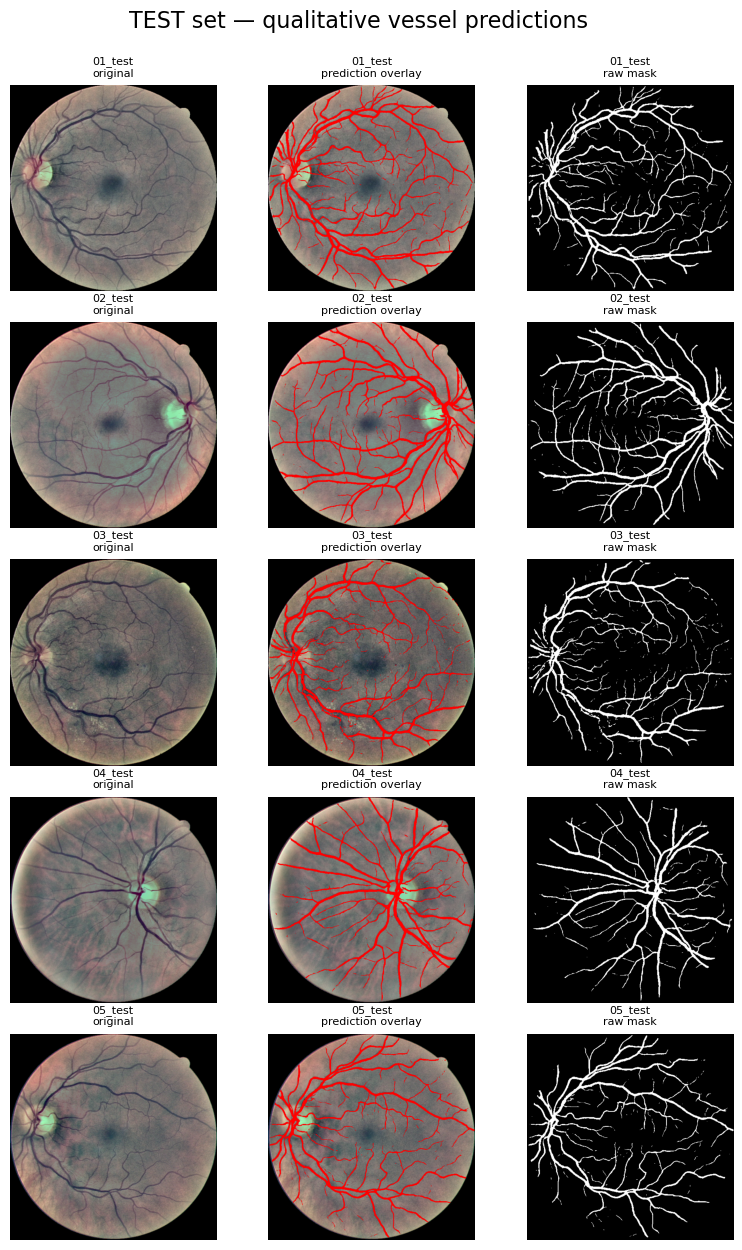

In [ ]:
# quick visual check (5 examples) 
def load_rgb(p):               # helper
    a = cv2.imread(str(p), cv2.IMREAD_COLOR)
    return cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

examples = list(TEST_IMG.glob("*.png"))[:5]
fig, axes = plt.subplots(len(examples), 3, figsize=(10, 3*len(examples)))
plt.subplots_adjust(wspace=0, hspace=0.15)

for r, img_p in enumerate(examples):
    stem = img_p.stem
    orig = load_rgb(img_p)
    pred = load_rgb(PRED_DIR / f"{stem}_pred.png")[:,:,0]   # gray
    overlay = orig.copy()
    overlay[pred>0, :] = [255, 0, 0]                        # red vessels

    panels = [orig, overlay, cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)]
    titles = ["original", "prediction overlay", "raw mask"]
    for ax, im, t in zip(axes[r], panels, titles):
        ax.imshow(im); ax.axis("off"); ax.set_title(f"{stem}\n{t}", fontsize=8)

plt.suptitle("TEST set — qualitative vessel predictions", fontsize=16, y=0.93)
plt.show()